# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# Check the present working directory
!pwd

/workspace/cd1971 Data Scientist Capstone/Bertelsmann_Arvato Project Workspace


### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz) from the Downloads section in the classroom, and upload it into the workspace. After you upload the tar file to the present working  directory, **/workspace/cd1971 Data Scientist Capstone/Bertelsmann_Arvato Project Workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 


In [2]:
import requests
import tarfile
import os


def download_and_extract(url, extract_to='.'):
    """
    Downloads a tar.gz file from a URL and extracts it to a directory.
    Args:
    - url (str): URL of the tar.gz file to download.
    - extract_to (str): Directory path to extract the contents of the tar.gz file.
    """
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Download the file
    print("Downloading the file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.raw.read())
        print("Download completed.")
    else:
        print("Failed to download the file.")
        return

    # Extract the tar.gz file
    print("Extracting the file...")
    try:
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print("Extraction completed.")
    except Exception as e:
        print(f"Failed to extract the file: {e}")
    finally:
        # Optionally remove the tar.gz file after extraction
        os.remove(filename)
        print("Downloaded tar.gz file removed.")

# URL of the tar.gz file
url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# Call the function with the URL
download_and_extract(url)



Download completed.
Extracting the file...
Extraction completed.
Downloaded tar.gz file removed.



### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

# magic word for producing visualizations in notebook
%matplotlib inline

# scikit-learn 
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

**1. Load the datasets**

In [2]:
# Load the first 625000 (aprox. 70% of data) rows from "Udacity_AZDIAS_052018.csv" to avoid memory overload
azdias_sample = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False, nrows=625000)
azdias_sample.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [3]:
# load the "Udacity_CUSTOMERS_052018.csv" dataset
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
customers.head() 

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


**2. We will first start working on the AZDIAS (German General Population), to get a grip of the data:**

In [4]:
azdias_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625000 entries, 0 to 624999
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 1.7+ GB


**2.1. Handle missing values in columns for azdias_sample**

In [5]:
#Let´s now check on missing data:
azdias_sample.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               52180
ALTER_HH                 52180
ALTER_KIND1             568200
                         ...  
WOHNDAUER_2008           52180
WOHNLAGE                 65845
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [6]:
#After checking on the excel "Dias Attributes", we see that the missing data is even bigger that we thought at first. 
#Let´s try to get a full picture of the missing values, by cross-referrencing those: 
DIAS_Attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
DIAS_Attributes.reset_index(drop=True, inplace=True)
del DIAS_Attributes['Unnamed: 0']
DIAS_Attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [7]:
DIAS_Attributes['Attribute'] = DIAS_Attributes['Attribute'].ffill()
DIAS_Attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [8]:
#Based on the excel, let´s identify every value that is actually a NaN value
nan_values = DIAS_Attributes[DIAS_Attributes['Meaning'].str.contains('unknown|no classification possible' , case=False, na=False)]
nan_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [9]:
#Use nan_values as a mapping to replace the values in the azdias_sample dataset to NaN
for attribute in nan_values['Attribute'].dropna().unique():
    if attribute in azdias_sample.columns: 
        # get all the values to replace for each attribute:
        values = nan_values[nan_values['Attribute'] == attribute]['Value']
        
        #flatten, split by coma, strip white spaces and convert to numeric if needed
        replace_vals = pd.Series(','.join(values.dropna().astype(str)).split(',')).str.strip()
        
        #Convert to numeric if the column is numeric:
        if pd.api.types.is_numeric_dtype(azdias_sample[attribute]):
            replace_vals = pd.to_numeric(replace_vals, errors='coerce')
        
        #replace in the azdias_sample
        azdias_sample[attribute].replace(replace_vals.tolist(), np.nan, inplace=True)   

In [10]:
azdias_sample.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [11]:
#Let´s check on the highest percentage of missing data:
nan_percent = azdias_sample.isna().mean().sort_values(ascending=False) * 100
nan_percent.head(20)

ALTER_KIND4                    99.86496
TITEL_KZ                       99.75792
ALTER_KIND3                    99.30128
ALTER_KIND2                    96.69616
ALTER_KIND1                    90.91200
AGER_TYP                       76.98528
EXTSEL992                      73.42272
KK_KUNDENTYP                   65.63376
KBA05_BAUMAX                   53.47632
ALTER_HH                       34.88912
ALTERSKATEGORIE_FEIN           29.60304
D19_BANKEN_ONLINE_QUOTE_12     28.92784
D19_LETZTER_KAUF_BRANCHE       28.92784
D19_KONSUMTYP                  28.92784
D19_LOTTO                      28.92784
D19_TELKO_ONLINE_QUOTE_12      28.92784
D19_VERSAND_ONLINE_QUOTE_12    28.92784
D19_SOZIALES                   28.92784
D19_GESAMT_ONLINE_QUOTE_12     28.92784
D19_VERSI_ONLINE_QUOTE_12      28.92784
dtype: float64

In [12]:
# let´s have a more general approach to the missing data and in the complete dataset:
nan_percent.describe()

count    366.000000
mean      11.411473
std       13.754544
min        0.000000
25%        0.549440
50%       11.949440
75%       13.095360
max       99.864960
dtype: float64

In [13]:
#Based on the statistics on nan_percent, let´s create the necessary bins:
bins = [0, 1, 10, 20, 30, 50, 75, 100]
labels = ['0%', '1-10%', '10-20%', '20-30%', '30-50%', '50-75%', '>75%']

# Transform nan_percent series into these bins
cols_percent_nan = pd.cut(nan_percent, bins=bins, labels=labels, include_lowest=True)

# Count how many columns fall into each category
count_cols = cols_percent_nan.value_counts().sort_index()

print(count_cols)

0%        106
1-10%      15
10-20%    225
20-30%     10
30-50%      1
50-75%      3
>75%        6
Name: count, dtype: int64


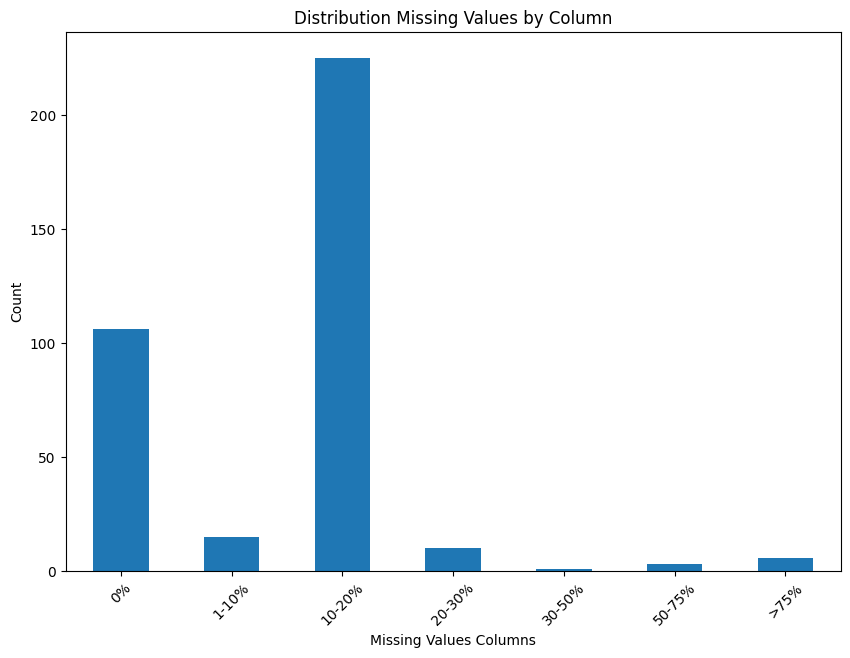

In [14]:
#Now let's visualize the results: 
plt.figure(figsize=(10, 7))
count_cols.plot(kind='bar')
plt.title('Distribution Missing Values by Column')
plt.xlabel('Missing Values Columns')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show();

In [15]:
#Check on the percentage of columns that have more than 20% of missing values 
total_columns = len(nan_percent)
high_missing = nan_percent[nan_percent >= 20]
num_high_missing = high_missing.count()
percent_high_missing = (num_high_missing/ total_columns) * 100
round(percent_high_missing, 2) 

5.46

Based on this information, we can see that: 
- 6 columns have more than 75% missing values 
- 3 columns have between 50% and 75% missing values 
- 1 columsn have 50% missing values
- 10 columns have 20-30% missing values 
- 5.46% of colums have ≥20% missing data


Thanks to the statistics we run on percent_nan, we can also add that: 
- 50% of the columns have around 11,9% missing values 
- 25% of the colums have under 0,5% missing values. 

Therefore, it would make sense to drop columns with ≥20% missing values.
- Imputing them would be unreliable
- Removing them would increase the quality of the data. 


In [16]:
#Drop columns that have ≥20% missing data:
azdias_sample_cleaned = azdias_sample.drop(columns=nan_percent[nan_percent >= 20].index)

In [17]:
#Let´s check if we dropped our columns correctly
nan_percent_cleaned = azdias_sample_cleaned .isna().mean().sort_values(ascending=False) * 100
nan_percent_cleaned.describe()

count    346.000000
mean       8.947127
std        6.256882
min        0.000000
25%        0.137360
50%       11.949440
75%       11.949440
max       17.750400
dtype: float64

**2.2. Handling missing Values azdias_sample_cleaned for rows** 

In [18]:
# Check the rows with nan values and pull the statistics:
nan_rows = azdias_sample_cleaned.isna().sum(axis=1)
missing_rows_percentage = (nan_rows/ azdias_sample_cleaned.shape[1])*100
missing_rows_percentage.describe()

count    625000.000000
mean          8.947127
std          21.344807
min           0.000000
25%           0.000000
50%           0.000000
75%           0.867052
max          71.387283
dtype: float64

We see that 75% of the rows have only 0.8% missing values. This is pretty good.
Now let´s deep-dive into the other 25% of the rows: 

In [19]:
# 75th percentile threshold
q75 = missing_rows_percentage.quantile(0.75)

# Filter for rows above the 75th percentile (i.e., top 25% most missing data)
high_missing_rows = missing_rows_percentage[missing_rows_percentage > q75]
high_missing_rows

0         68.786127
3          1.156069
11        69.075145
12        18.208092
13        19.075145
            ...    
624983    68.786127
624986    69.075145
624990    18.208092
624996    69.075145
624997    68.786127
Length: 141048, dtype: float64

In [20]:
sorted_missing_freqs = high_missing_rows.value_counts().sort_index(ascending=False)
sorted_missing_freqs.head(50)

71.387283        1
70.520231        8
70.231214       24
69.942197        5
69.653179        7
69.364162       19
69.075145    32436
68.786127    19758
65.317919       13
65.028902      310
64.739884      234
64.450867       88
64.161850       71
63.872832     2882
63.583815     7873
63.294798     1985
63.005780      133
62.716763        1
62.427746        1
62.138728        3
61.849711        2
61.560694        4
61.271676        4
60.982659        1
60.693642        1
60.404624        9
59.826590        1
59.537572        4
58.381503        1
58.092486        1
57.803468        6
57.514451        7
57.225434       14
56.936416       31
56.647399       22
56.358382       65
56.069364      237
55.780347       83
55.491329      545
55.202312       87
54.913295      149
54.624277     1562
54.335260       80
54.046243      224
53.757225     1087
53.468208       12
53.179191       29
52.890173       17
52.601156      149
52.312139      218
Name: count, dtype: int64

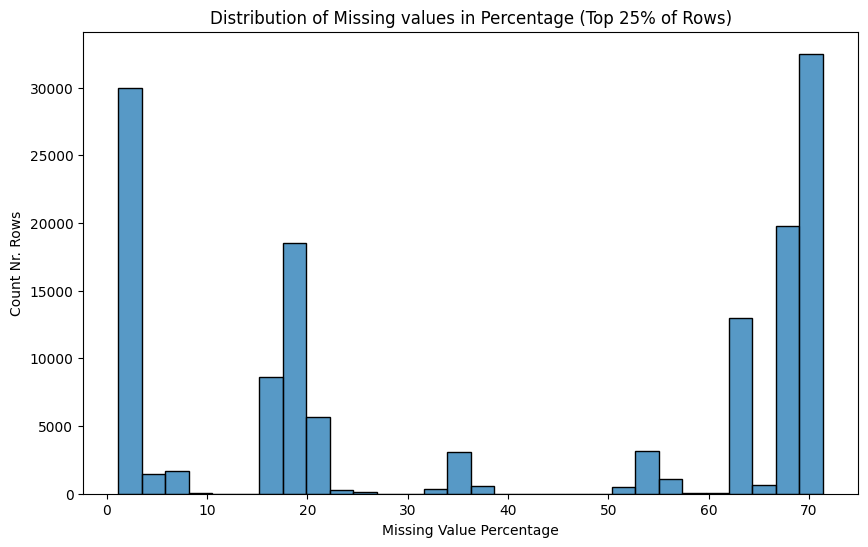

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(high_missing_rows , bins=30)
plt.title('Distribution of Missing values in Percentage (Top 25% of Rows)')
plt.xlabel('Missing Value Percentage')
plt.ylabel('Count Nr. Rows')
plt.show();

After our analysis of the q75 of missing values in rows, we can see that there is a big cluster of missing values starting from 63%. Therefore, it would make sense to drop rows with more than 60% of missing values to increase data quality. 


In [22]:
#Drop rows that have ≥60% missing data:
azdias_sample_cleaned_rows = azdias_sample_cleaned.drop(index=high_missing_rows[high_missing_rows >= 60].index)
azdias_sample_cleaned_rows.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [23]:
#Now test if the dropped rows worked succesfully
nan_rows_cleaned = azdias_sample_cleaned_rows.isna().sum(axis=1)
missing_rows_percentage_cleaned = (nan_rows_cleaned/ azdias_sample_cleaned_rows.shape[1])*100
missing_rows_percentage_cleaned.describe()

count    559127.000000
mean          2.005282
std           7.177004
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.826590
dtype: float64

**2.3. Handling dtypes**

In [24]:
#Rename the cleaned dataset, to mame it easier to work
azdias_sample_1 = azdias_sample_cleaned_rows 

In [25]:
# Summary of data types
azdias_sample_1.dtypes.value_counts()

float64    254
int64       87
object       5
Name: count, dtype: int64

**2.3.1. Object dtypes**

In [26]:
#Let´s start with the object dtypes: 
azdias_sample_1.select_dtypes(include='object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,1992-02-10 00:00:00,W
2,4C,4,24,1992-02-12 00:00:00,W
3,2A,2,12,1997-04-21 00:00:00,W
4,6B,6,43,1992-02-12 00:00:00,W
5,8C,8,54,1992-02-12 00:00:00,W


In [27]:
#We now check for NaN values: 
azdias_sample_1.select_dtypes(include='object').isnull().sum()

CAMEO_DEU_2015     4013
CAMEO_DEUG_2015    4013
CAMEO_INTL_2015    4013
EINGEFUEGT_AM         0
OST_WEST_KZ           0
dtype: int64

In [28]:
#Let´s impute the CAMEO NaN values with the mode: 
for col in ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
    mode_value = azdias_sample_1[col].mode()[0]
    azdias_sample_1[col].fillna(mode_value, inplace=True)
    
#We now check for NaN values: 
azdias_sample_1.select_dtypes(include='object').isnull().sum()

CAMEO_DEU_2015     0
CAMEO_DEUG_2015    0
CAMEO_INTL_2015    0
EINGEFUEGT_AM      0
OST_WEST_KZ        0
dtype: int64

In [29]:
#Change 'EINGEFUEGT_AM' to datetime
azdias_sample_1['EINGEFUEGT_AM'] = pd.to_datetime(azdias_sample_1['EINGEFUEGT_AM'], errors='coerce')
azdias_sample_1['EINGEFUEGT_AM'].head()

1   1992-02-10
2   1992-02-12
3   1997-04-21
4   1992-02-12
5   1992-02-12
Name: EINGEFUEGT_AM, dtype: datetime64[ns]

In [30]:
# Test imputing process
azdias_sample_1.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 559127 entries, 1 to 624999
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEU_2015   559127 non-null  object
 1   CAMEO_DEUG_2015  559127 non-null  object
 2   CAMEO_INTL_2015  559127 non-null  object
 3   OST_WEST_KZ      559127 non-null  object
dtypes: object(4)
memory usage: 21.3+ MB


**2.3.2. Numerical dtypes**

In [31]:
nan_columns = azdias_sample_1.columns[azdias_sample_1.isnull().any()]
list(nan_columns)

['ANZ_HH_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'EWDICHTE',
 'FIRMENDICHTE',
 'GEBAEUDETYP_RASTER',
 'GEMEINDETYP',
 'GFK_URLAUBERTYP',
 'HEALTH_TYP',
 'HH_DELTA_FLAG',
 'INNENSTADT',
 'KBA05_ALTER1',
 'KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4',
 'KBA05_ANHANG',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_AUTOQUOT',
 'KBA05_CCM1',
 'KBA05_CCM2',
 'KBA05_CCM3',
 'KBA05_CCM4',
 'KBA05_DIESEL',
 'KBA05_FRAU',
 'KBA05_GBZ',
 'KBA05_HERST1',
 'KBA05_HERST2',
 'KBA05_HERST3',
 'KBA05_HERST4',
 'KBA05_HERST5',
 'KBA05_HERSTTEMP',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_KRSKLEIN',
 'KBA05_KRSOBER',
 'KBA05_KRSVAN',
 'KBA05_KRSZUL',
 'KBA05_KW1',
 'KBA05_KW2',
 'KBA05_KW3',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB',
 'KBA05_MOD1',
 'KBA05_MOD2',
 'KBA05_MOD

In [32]:
nan_summary = azdias_sample_1[nan_columns].isnull().sum().sort_values(ascending=False)
nan_summary.head(50)

KKK                45076
REGIOTYP           45076
W_KEIT_KIND_HH     41402
KBA05_AUTOQUOT     37962
KBA05_MAXAH        37958
KBA05_MOD2         37958
KBA05_MOD1         37958
KBA05_MAXVORB      37958
KBA05_MAXSEG       37958
KBA05_MAXHERST     37958
KBA05_MAXBJ        37958
KBA05_KW3          37958
KBA05_MOD4         37958
KBA05_KW2          37958
KBA05_KW1          37958
KBA05_KRSZUL       37958
KBA05_KRSVAN       37958
KBA05_KRSOBER      37958
KBA05_KRSKLEIN     37958
KBA05_KRSHERST3    37958
KBA05_KRSHERST2    37958
KBA05_MOD3         37958
KBA05_MOD8         37958
KBA05_KRSAQUOT     37958
KBA05_SEG9         37958
KBA05_ZUL4         37958
KBA05_ZUL3         37958
KBA05_ZUL2         37958
KBA05_ZUL1         37958
KBA05_VORB2        37958
KBA05_VORB1        37958
KBA05_VORB0        37958
KBA05_SEG8         37958
KBA05_MOTOR        37958
KBA05_SEG7         37958
KBA05_SEG6         37958
KBA05_SEG5         37958
KBA05_SEG3         37958
KBA05_SEG2         37958
KBA05_SEG10        37958


In [33]:
#Fill NaN with median values
azdias_sample_1.fillna(azdias_sample_1.median(numeric_only=True), inplace=True)
print(azdias_sample_1.isnull().sum().sum())

0


**2.4. Transform data**

In preparation for machine learning, we will now transform the cleaned data: 

In [34]:
azdias_new = azdias_sample_1
azdias_new.dtypes.value_counts()

float64           254
int64              87
object              4
datetime64[ns]      1
Name: count, dtype: int64

**2.4.1 Transform Categorical Data**

We will use LabelEncoder()

In [35]:
for col in azdias_new.select_dtypes(include='object').columns: 
    azdias_new[col] = azdias_new[col].astype(str) 
    azdias_new[col] = LabelEncoder().fit_transform(azdias_new[col])

In [36]:
azdias_new.dtypes.value_counts()

float64           254
int64              91
datetime64[ns]      1
Name: count, dtype: int64

All object dtypes have been transformed to numerical, which means that these are not encoded.

**2.4.2. Transform Numerical Data**

Since I am working on demographic data, it makes sense to user Standard Scaling for the Z-Score Normalization: 

In [37]:
azdias_new.shape

(559127, 346)

In [38]:
#Due to the fact that our dataset is large, we will try scaling the data for a sample of the dataset: 
# 1. Create numerical columns 
sample = azdias_new.head(100).copy()

# 2. Select the numerical columns 
numerical_columns = sample.select_dtypes(include=['int', 'float']).columns

In [39]:
# 3. Reduce memory usage before scaling
sample.loc[:, numerical_columns] = sample[numerical_columns].astype('float32')

In [40]:
# 4. Create a sample of the dataframe that we are going to fit 
azdias_fit_sample = azdias_new.sample(n=200000, random_state=42)
azdias_fit_sample[numerical_columns] = azdias_fit_sample[numerical_columns].astype('float32')

In [41]:
# 5. Fit scaler on sample
scaler = StandardScaler()
scaler.fit(azdias_fit_sample[numerical_columns].sample(n=10000, random_state=42))

StandardScaler()

In [42]:
# 6. Scale in chunks
chunk_size = 50000
azdias_scaled = azdias_fit_sample.copy()

for start_row in range(0, azdias_scaled.shape[0], chunk_size):
    end_row = min(start_row + chunk_size, azdias_scaled.shape[0])
    chunk = azdias_scaled.iloc[start_row:end_row].copy()

    scaled_chunk = scaler.transform(chunk[numerical_columns])
    
    # Use iloc with get_indexer to assign to correct columns by position
    azdias_scaled.iloc[start_row:end_row, azdias_scaled.columns.get_indexer(numerical_columns)] = scaled_chunk

In [43]:
azdias_scaled.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
4482,-0.081234,-0.114162,-0.388520,-0.118011,3.679896,0.256373,-0.367988,-0.053837,-0.164504,0.847019,...,-0.361097,-1.075280,-0.490529,0.721433,-1.851215,0.557449,-0.540178,0.437242,-1.037711,0.162931
354025,0.724370,1.253707,0.337935,-0.118011,-0.302891,0.256373,0.399026,-0.053837,-1.170032,0.847019,...,-2.090905,-1.778193,-2.031812,-1.793021,1.081449,0.557449,1.511781,0.437242,0.963660,-0.770772
411376,1.531982,0.432985,-0.206906,-0.118011,-0.302891,-0.626453,-0.176234,-0.053837,-1.170032,0.847019,...,-0.361097,-0.372368,0.125984,0.003017,1.081449,-1.025015,-1.566158,0.437242,-1.037711,0.162931
347878,-1.451867,-0.661310,-0.449058,-0.118011,-0.302891,-0.626453,-0.431905,-0.053837,0.841024,1.306831,...,0.503806,1.384913,1.359011,1.080640,1.081449,0.557449,1.511781,1.850436,0.963660,0.162931
613767,1.037384,0.706559,0.822238,-0.118011,-0.302891,-0.626453,0.462944,-0.053837,-0.164504,0.847019,...,1.368710,-0.020912,0.434241,1.439848,1.081449,-2.607479,-0.027188,1.143839,0.963660,-0.770772


In [44]:
azdias_scaled.shape

(200000, 346)

**3. Now that AZDIAS dataset is clean and transformed, We will working on the CUSTOMERS dataset:**

**3.1. Handle missing values in columns for customers**

As we analyzed the NaN values for azdias, we are going to drop the same columns:

In [45]:
# 1st let´s check on the columns that are different between both datasets. 
#We know that there are three columns that customers have, plus the ones we deleted from azdias:
print(azdias_sample_1.shape)
print(customers.shape)
set(azdias_sample_1.columns) ^ set(customers.columns)

(559127, 346)
(191652, 369)


{'AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CUSTOMER_GROUP',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'ONLINE_PURCHASE',
 'PRODUCT_GROUP',
 'TITEL_KZ'}

In [46]:
# We got the columns, let´s drop them: 
customers_1 = customers.drop(['AGER_TYP', 'ALTERSKATEGORIE_FEIN', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
                            'ALTER_KIND4', 'CUSTOMER_GROUP', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
                            'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12',
                            'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP',
                            'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'TITEL_KZ'], axis=1)
customers_1.shape

(191652, 346)

In [47]:
#Use the created mapping drom DIAS_Attributes to replace values to NaN: 
for attribute in nan_values['Attribute'].dropna().unique():
    if attribute in customers_1.columns: 
        # get all the values to replace for each attribute:
        values = nan_values[nan_values['Attribute'] == attribute]['Value']
        
        #flatten, split by coma, strip white spaces and convert to numeric if needed
        replace_vals = pd.Series(','.join(values.dropna().astype(str)).split(',')).str.strip()
        
        #Convert to numeric if the column is numeric:
        if pd.api.types.is_numeric_dtype(customers_1[attribute]):
            replace_vals = pd.to_numeric(replace_vals, errors='coerce')
        
        #replace in the azdias_sample
        customers_1[attribute].replace(replace_vals.tolist(), np.nan, inplace=True)   

In [48]:
customers_1.head(10)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,9.0,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3,1,4
2,143872,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,143888,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3
6,143904,1.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,6.0,...,4.0,3.0,4.0,2.0,6.0,9.0,7.0,1,1,4
7,143910,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,5.0,...,3.0,1.0,2.0,1.0,6.0,9.0,3.0,3,1,4
8,102160,3.0,74.0,2.0,0.0,1.0,82.0,0.0,3.0,3.0,...,NaN,8.0,11.0,9.0,6.0,3.0,4.0,3,2,4
9,102173,1.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,5.0,1,1,3


In [49]:
#Let´s check on the highest percentage of missing data:
nan_percent_customers = customers_1.isna().mean().sort_values(ascending=False) * 100
nan_percent_customers.head(20)

KKK                31.340137
REGIOTYP           31.340137
W_KEIT_KIND_HH     29.708534
KBA05_AUTOQUOT     29.696533
KBA05_ALTER2       29.696012
KBA05_HERST5       29.696012
KBA05_KW2          29.696012
KBA05_KW1          29.696012
KBA05_KRSZUL       29.696012
KBA05_KRSVAN       29.696012
KBA05_KRSOBER      29.696012
KBA05_KRSKLEIN     29.696012
KBA05_KRSHERST3    29.696012
KBA05_KRSHERST2    29.696012
KBA05_KRSHERST1    29.696012
KBA05_KRSAQUOT     29.696012
KBA05_HERST4       29.696012
KBA05_ALTER3       29.696012
KBA05_KW3          29.696012
KBA05_HERST2       29.696012
dtype: float64

In [50]:
# let´s have run sume statistics on the NaN values
nan_percent_customers.describe()

count    346.000000
mean      19.004481
std       12.599353
min        0.000000
25%        0.387160
50%       26.757352
75%       26.757352
max       31.340137
dtype: float64

In [51]:
#Based on the statistics on customers_nan_percent, let´s create the necessary bins:
bins = [0, 1, 10, 20, 26, 30, 40, 75, 100]
labels = ['0%', '1-10%', '10-20%', '20-25%', '25-30%', '30-40%', '40-75%', '>75%']

# Transform nan_percent series into these bins
customers_cols_percent_nan = pd.cut(nan_percent_customers, bins=bins, labels=labels, include_lowest=True)

# Count how many columns fall into each category
customers_count_cols = customers_cols_percent_nan.value_counts().sort_index()

print(customers_count_cols)

0%         87
1-10%      20
10-20%      0
20-25%     19
25-30%    218
30-40%      2
40-75%      0
>75%        0
Name: count, dtype: int64


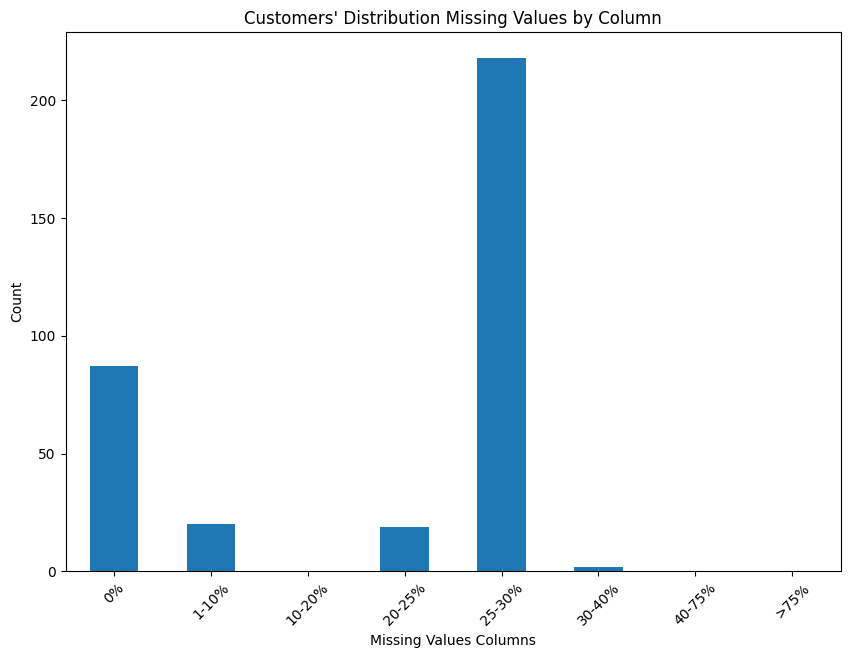

In [52]:
#Now let's visualize the results: 
plt.figure(figsize=(10, 7))
customers_count_cols.plot(kind='bar')
plt.title("Customers' Distribution Missing Values by Column")
plt.xlabel('Missing Values Columns')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show();

Thanks to the above findings, we can say that:

- The mean of missing values for the dataset is 19% 
- The max of missing values is 31.3%, a little higher as in the azdias dataset after cleaning the columns
- However, we can definitely infer that after deleting the same columns as we did for azdias, we already dealt with the main missing values. 
- We will tackle the rest of the missing values through: 
    -> dealing with NaN values in rows 
    -> NaN imputation

**3.2. Handling missing Values customers for rows**

In [53]:
# Check the rows with nan values and pull the statistics:
nan_rows_customers = customers_1.isna().sum(axis=1)
missing_rows_percentage_customers = (nan_rows_customers/ customers_1.shape[1])*100
missing_rows_percentage_customers.describe()

count    191652.000000
mean         19.004481
std          29.954292
min           0.000000
25%           0.000000
50%           0.000000
75%          63.583815
max          71.387283
dtype: float64

We see that 75% of the rows have only more than 63% missing values. This is pretty high. Now let´s pick up on those rows and see if we drop them or impute them:

In [54]:
# Set threshold (e.g., 60%)
threshold = 60

In [55]:
# Filter rows to drop
rows_to_drop = missing_rows_percentage_customers[missing_rows_percentage_customers > threshold].index

In [ ]:
# Drop rows
customers_cleaned = customers_1.drop(index=rows_to_drop)
customers_cleaned.shape

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')